In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import advanced_processor_chain_factory
from data import preprocess_data, load_dataset
from evaluation import analysis, cluster_analysis

In [2]:
def last_layer_activations(model, X):
    acs = [X] + (model.n_layers_ - 1) * [None]
    return model._forward_pass(acs)[model.n_layers_ - 2]

In [3]:
dataset = load_dataset()
DEBUG = False

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    *preprocess_data(dataset, processor_chain=advanced_processor_chain_factory.create('lem'), debug=DEBUG))

Pandas Apply:   0%|          | 0/45000 [00:00<?, ?it/s]

In [5]:
vectorizer = CountVectorizer(max_features=2000)

In [6]:
vectorizer.fit(pd.concat([X_train, X_test]))
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(1000, 500, 250, 5), activation='tanh', warm_start=True)
mlp.fit(X_train_vec, Y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(1000, 500, 250, 5),
              warm_start=True)

In [8]:
analysis(Y_test, mlp.predict(X_test_vec))

Report: Classification
               precision    recall  f1-score   support

    positive       0.84      0.84      0.84      5616
    negative       0.84      0.84      0.84      5634

    accuracy                           0.84     11250
   macro avg       0.84      0.84      0.84     11250
weighted avg       0.84      0.84      0.84     11250

Matrix: Confusion
 [[4722  894]
 [ 894 4740]]
Accuracy:
 0.8410666666666666


0.8413205537806177

In [9]:
X_train_vec = last_layer_activations(mlp, X_train_vec)
X_test_vec = last_layer_activations(mlp, X_test_vec)

In [10]:
def plot_clustering(Y, X_train_pca):
    u_labels = np.unique(Y)
    for i in u_labels:
        points = X_train_pca[Y == i]
        plt.scatter(points[:, 0], points[:, 1], label=i)
    plt.show()

In [11]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_vec)
X_test_pca = pca.transform(X_test_vec)

# Show Clusters

Let's see something weird. Features generated by the multi-layer perceptron for train data, are perfect for
even one-dimensional clustering, but it seems they are not good at all for separating our test data.

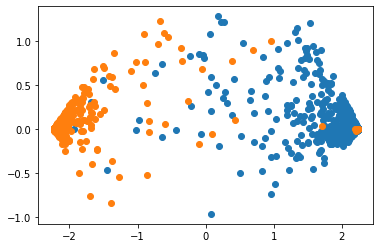

In [12]:
plot_clustering(Y_train, X_train_pca)

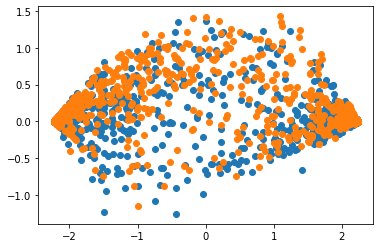

In [13]:
plot_clustering(Y_test, X_test_pca)

## (Bonus) Train a Logistic Regression with the New Representation
As the two-dimensional representation for transformed test data was a total disaster, we wondered to know if this data
is even predictable at all with a model trained with our transformed train data. So we decided to measure
test data performance on a Logistic Regression model trained on our transformed train data.
We measure train and test performance with conventional accuracy metric and with two clustering measures which will be
also used in the next part.

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_vec, Y_train)
for name, y, x in [('Training', Y_train, X_train_vec), ('Testing', Y_test, X_test_vec)]:
    print('%s Accuracy: %f' % (name, metrics.accuracy_score(y, lr.predict(x))))
    print('%s Rand Score: %f' % (name, metrics.rand_score(y, lr.predict(x))))
    print('%s Fowlkers Mallows Score: %f' % (name, metrics.fowlkes_mallows_score(y, lr.predict(x))))

Training Accuracy: 0.991348
Training Rand Score: 0.982845
Training Fowlkers Mallows Score: 0.982845
Testing Accuracy: 0.841333
Testing Rand Score: 0.732993
Testing Fowlkers Mallows Score: 0.732971


# Agglomerative Clustering

In [15]:
agg2 = AgglomerativeClustering(n_clusters=2)
agg5 = AgglomerativeClustering (n_clusters=5)
Y_agg2 = agg2.fit_predict(X_train_vec, Y_train)
Y_agg5 = agg5.fit_predict(X_train_vec, Y_train)

## Number of Clusters = 2

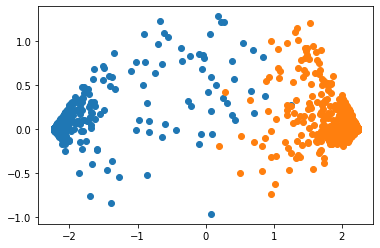

In [16]:
plot_clustering(Y_agg2, X_train_pca)

## Number of Clusters = 5

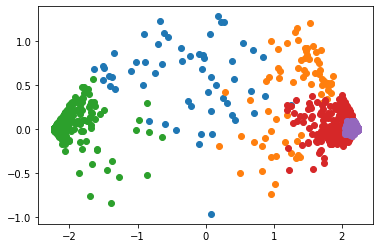

In [17]:
plot_clustering(Y_agg5, X_train_pca)

## Training Loss
(This approuch can't be used for unseen data)

In [18]:
cluster_analysis(Y_train, Y_agg2)

Test Evaluation:
rand_score: 0.9815651641804476
fowlkes_mallows_score: 0.9815646418860272


# KMeans Clustering

In [19]:
kmeans2 = KMeans(n_clusters=2)
kmeans5 = KMeans (n_clusters=5)
Y_kmeans2 = kmeans2.fit_predict(X_train_vec, Y_train)
Y_kmeans5 = kmeans5.fit_predict(X_train_vec, Y_train)

## Number of Clusters = 2

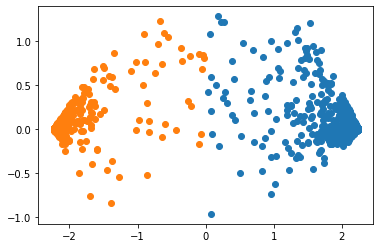

In [20]:
plot_clustering(Y_kmeans2, X_train_pca)

## Number of Clusters = 5

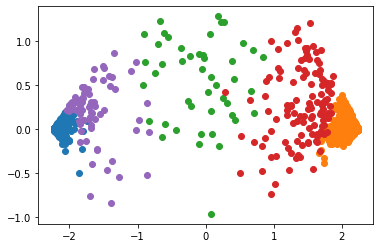

In [21]:
plot_clustering(Y_kmeans5, X_train_pca)

## Performance on Training Data

In [22]:
cluster_analysis(Y_train, Y_kmeans2)

Test Evaluation:
rand_score: 0.9824379340732181
fowlkes_mallows_score: 0.9824374159361037


## Performance on Test Data

In [23]:
cluster_analysis(Y_test, kmeans2.predict(X_test_vec))

Test Evaluation:
rand_score: 0.7331145445027212
fowlkes_mallows_score: 0.7330911968045254


# GMM Clustering

## Number of Clusters = 2

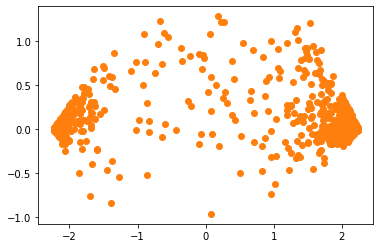

In [24]:
gmm2 = GaussianMixture(n_components=2)
Y_gmm2 = gmm2.fit_predict(X_train_vec, Y_train)
plot_clustering(Y_gmm2, X_train_pca)

## Number of Clusters = 5

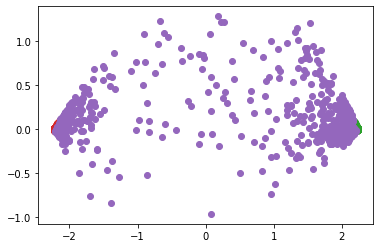

In [25]:
gmm5 = GaussianMixture (n_components=5)
Y_gmm5 = gmm5.fit_predict(X_train_vec, Y_train)
plot_clustering(Y_gmm5, X_train_pca)

## Performance on Training Data

In [26]:
cluster_analysis(Y_train, Y_gmm2)

Test Evaluation:
rand_score: 0.9391562328870101
fowlkes_mallows_score: 0.9392216058065816


## Performance on Test Data

In [27]:
cluster_analysis(Y_test, gmm2.predict(X_test_vec))

Test Evaluation:
rand_score: 0.7201871020633933
fowlkes_mallows_score: 0.7236858866273704


# Cluster Member's Similarity in Action

In [28]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_vec)
Y_train_pred = kmeans.predict(X_train_vec)

Cluster 0:
0	movie smile begin end partly humor partly meg ryan perfect character always one well feel good movie see hopefully dvd soon
1	watch movie almost quite kid naturally move tear story fox family fantastic scenery hokkaido excellent storytelling last not least wonderful soundtrack provide rare intimacy protagonist still search copy gorgeous soundtrack german viewer might useful know defa dub one worth listen tape defa br keep view first one
2	ok everybody agree good season first kill boone bad desicion also kill other bad blame director writer bad boy still think good scifi series ever sorry guy can not help see quality series decrease first season still easy accept liam new main character boone really mysterious thing shock lilli write story something not deserve get blonde chick call renee absolutely character taelon stay mysterious stay wonder true plan till end true suspence conversation zoor daan sometimes brillianti understand jump episode th th th season may not underst

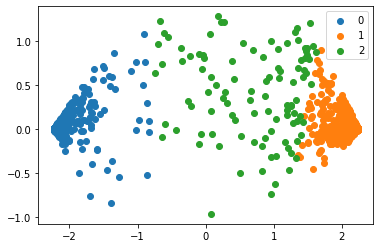

In [29]:
for i in range(3):
    print(f'Cluster {i}:')
    points = X_train_pca[Y_train_pred == i]
    plt.scatter(points[:, 0], points[:, 1], label=i)
    for i, item in enumerate(X_train[Y_train_pred == i].head(5)):
        print(f'{i}\t{item}')
plt.legend()
plt.show()

# Fine-Tuning

## Without pre-training

In [30]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1uykBJxWH5v5BsSuuwM0r9WLiKWQrDiDJ', dest_path=('./dataset2.csv'))
dataset2 = pd.read_csv('./dataset2.csv')

In [31]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(
    *preprocess_data(dataset2, processor_chain=advanced_processor_chain_factory.create('lem'), debug=False))

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [32]:
vectorizer2 = CountVectorizer(max_features=2000)
vectorizer2.fit(pd.concat([X_train2, X_test2]))
X_train_vec2 = vectorizer2.transform(X_train2)
X_test_vec2 = vectorizer2.transform(X_test2)

In [33]:
model = MLPClassifier(hidden_layer_sizes=(1000, 500, 250, 5), activation='tanh')
model.fit(X_train_vec2, Y_train2)
analysis(Y_test2, model.predict(X_test_vec2))

Report: Classification
               precision    recall  f1-score   support

    positive       0.87      0.66      0.75        71
    negative       0.66      0.87      0.75        54

    accuracy                           0.75       125
   macro avg       0.77      0.77      0.75       125
weighted avg       0.78      0.75      0.75       125

Matrix: Confusion
 [[47 24]
 [ 7 47]]
Accuracy:
 0.752


/home/mryf/PycharmProjects/ml_final_project/venv/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.752

## With pre-training

In [34]:
X_train_vec2 = vectorizer.transform(X_train2)
X_test_vec2 = vectorizer.transform(X_test2)

In [35]:
mlp.partial_fit(X_train_vec2, Y_train2)
analysis(Y_test2, mlp.predict(X_test_vec2))

Report: Classification
               precision    recall  f1-score   support

    positive       0.89      0.72      0.80        71
    negative       0.71      0.89      0.79        54

    accuracy                           0.79       125
   macro avg       0.80      0.80      0.79       125
weighted avg       0.81      0.79      0.79       125

Matrix: Confusion
 [[51 20]
 [ 6 48]]
Accuracy:
 0.792


0.7868852459016393